# Introduction

This is a python notebook where I will be coding a neural network engine from scratch by following this amazing video from Mr Andrej Karpathy (<a href="https://www.youtube.com/watch?v=VMj-3S1tku0">Click Here</a>). 
Neural Networks are mathematical expressions that take in inputs as data (along with their weights and bias).

## What is micrograd ?
It is the implementation of the backpropagation step in neural networks. Backprop works by evaluating a gradient with a loss function (example: CrossEntropyLoss, MSE, MAE) with respect to the weights of the neural network. 
Calling <code>g.backward()</code> will:
1. start backprop from node 'g'
2. apply chain rule recursively (reminder: dy/dx = dy/du * du/dx. du/dx -> how 'u' will grow upon changing 'x').

In short, we find the derivating of node 'g' with respect to all nodes+inputs


In [2]:
## Library Imports

import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# creating the Value object and enabling functions such as addition and subtraction
class Value:
    def __init__(self, data, _children=(), _op="", label="") -> None:
        """
        data: value of the neuron (activation value)
        _children: set. used to store the children of the node
        label: neuron reference name
        """
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        # keeping track of derivative of the node
        self.grad = 0
        # store chain rule. by default does nothing
        self._backward = lambda: None

    def __repr__(self) -> str:
        """
        print the value stored within the Value object
        """
        return f"Value(data={self.data})"

    def __add__(self, other) -> int | float:
        # if we are trying to add integer to a Value object, convert the number into a Value object then extract its value and add
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            # here we accumulate gradient as it is possible we may have multivariable contribution backwards. depositing gradients from mutliple branches
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other) -> int | float:
        """
        other: usually this is the weight
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    # this is basically a fallback for if the __mul__ function does not get the inputs in the other self, other. to learn more about it try this link : https://stackoverflow.com/questions/5181320/under-what-circumstances-are-rmul-called

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        # self * 1/other = self/other
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        # subtract
        return self + (-other)

    def __pow__(self, other):
        # power function.
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            # multiplying out.grad is essnetial to the chain rule
            new_val = other - 1
            self.grad += other * (self.data**new_val) * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))
        out = Value(t, (self,), "tanh")

        def _backward():
            # derivative of the tanh func. starting from loss L
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [4]:
# code to visualize the neural network
# NOTE: this has been directly copied from the repo : https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/micrograd/micrograd_lecture_first_half_roughly.ipynb

from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            # label="{ %s | data %.4f }" % (n.label, n.data),
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [5]:
# # building a demo nn here
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
# output of nn
L = d * f
L.label = "L"
L1 = L.data

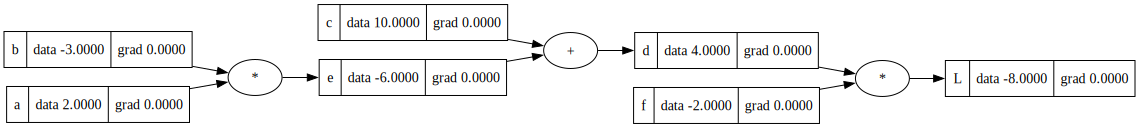

In [6]:
draw_dot(L)

In [7]:
# now we will be calculating the derivative of each node wrt L.
# we do this for the loss function wrt weights of the nn.
# we need to see how the weights are impacting the loss.



## Backpropagation
We want to calculate what is dL/dd given that L=d+f (calculating derivative of L wrt d) which is equal to f.

In [8]:
# f.grad = d.data
# d.grad = f.data
# c.grad = -2.0
# e.grad = -2.0
# a.grad = -2.0 * -3.0
# b.grad = -2.0 * 2.0

In [9]:
# funtion which basically holds the neural network
def nn():
    # function to build a neural network
    # here we also implement backprop

    h = 0.001

    # building a demo nn here
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    # output of nn
    L = d * f
    L.label = "L"
    L1 = L.data

    # building a demo nn here
    a = Value(2.0, label="a")
    # a.data += h
    b = Value(-3.0, label="b")
    # nudging a node by h to see what happens to gradient val
    b.data += h
    c = Value(10.0, label="c")
    # c.data += h
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    # output of nn
    L = d * f
    L.label = "L"
    L2 = L.data

    # calculating derivative of L wrt (whatever variable we add a small amount to in this case thats 'a' since a = Value(2.0 + h, label="a"))

    # derivative/grad = rise/run
    # gradient check: checking grad calc
    # next question: how does c impact L ?
    # to calc this we first calculate the derivative of d wrt c. # dd/dc. so (f(x+h) - f(x))/h -> ((c+ h +e) - (c+e))/h
    #  h/h = 1.0
    # so dd/de = 1.0

    # according to chain rule:
    # dL/c -> what we want
    # what we have: dL / dd , dd / dc
    # so dL/dc = dL/dd * dd/dc

    # dL/de = -2.0
    # what we want: dL/da = dL/de * de/da
    # so de/da = b

    print((L2 - L1) / h)


nn()

-3.9999999999995595


In [10]:
# activation func -> squashing func
import math
# an example of the operation inside a neuron

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432, label="b")
# calculating the activation value
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
# o = n.tanh()
#  tanh from eq
e = (2 * n).exp()
o = (e - 1) / (e + 1)

o.label = "o"
o.backward()

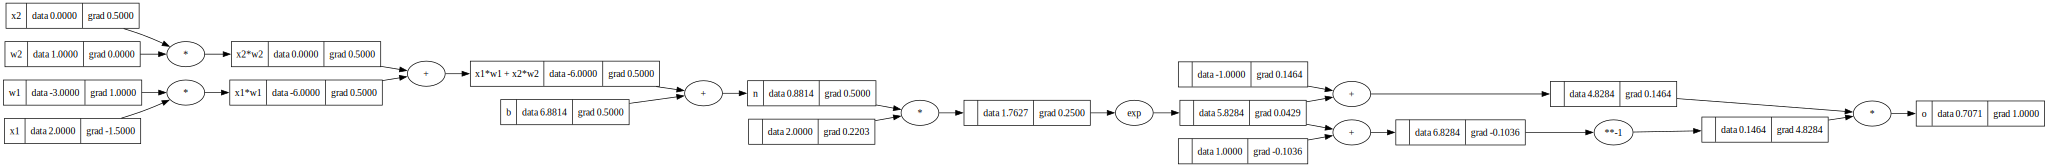

In [11]:
draw_dot(o)

In [12]:
# backward prop

# start from the top
# base case set o.grad() to 0
# o.grad = 1.0
o.backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()

In [13]:
# making a topological graph to iterate through the graph for backprop (automate the proces. fist go through each node's children and valls the func. after going through the children it adds itself)

# topo = []
# visited = set()


# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)


# build_topo(o)

# for node in reversed(topo):
#     node._backward()

In [14]:
a = Value(2.0)
a + 1

Value(data=3.0)

In [52]:
# neuron class
import random


class Neuron:
    # neuron class within which we will define incoming inputs/weights as well as its bias

    def __init__(self, nin):
        """
        nin: Number of inputs. Equivalent to number of neurons in input layer
        """
        # initializing collection of weights -> number of inputs/inital neurons
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # calls the equation to calculate activation value: (w * x) + b
        # if you are unfamilar with zip() check this out: https://www.geeksforgeeks.org/zip-in-python/
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        # apply activation function for non-linearity + suppress value within a specified range
        out = act.tanh()
        return out

    def parameters(self):
        """
        returns the weight list and the bias value for the neuron
        """
        return self.w + [self.b]


class Layer:
    # a layer contains multiple Neuron objects

    def __init__(self, nin, nout):
        """
        nin:  number of incoming neurons/weights for one Neuron in layer
        nout: number of outputs/how many neurons do you want in the layer
        """
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

    def parameters(self):
        """ """
        params = []
        for neuron in self.neurons:
            for p in neuron.parameters():
                params.append(p)
        return params


class MLP:
    # define number of layers and number of neurons in each layer

    def __init__(self, nin, nouts):
        """
        nin:   number of inputs
        nouts: list of layer sizes / number of neurons in each layer
        """
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
        # print("YESSSSS")

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x[0] if len(x) == 1 else x

    def parameters(self):
        """ """
        params = []
        for layer in self.layers:
            for neuron_param in layer.parameters():
                params.append(neuron_param)

        return params

    def no_params(self):
        return len(self.parameters())


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

n.no_params()

41

In [46]:
# loss: measure that shows how well a neural network is performing. loss = (pred - ground truth )^2 -> why square ? to always get a positive value. can also use abs as an alternative
# here we will implement MSE (mean squred error)
xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets
ypred = [n(x) for x in xs]  # prediction on input x.
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

# you only get 0 when yout same as ygt. ygt: y ground truth (actual value)

In [47]:
ypred

[Value(data=0.8719989265864847),
 Value(data=0.9277799654388478),
 Value(data=0.8620618789781906),
 Value(data=0.803794532326867)]

In [48]:
# analysis on the weight gradint
loss.backward()

In [53]:
n.parameters()

[Value(data=0.6624649433154961),
 Value(data=-0.6768820466996153),
 Value(data=0.6784022079686172),
 Value(data=-0.03706593274529024),
 Value(data=-0.3347749392232249),
 Value(data=-0.7138373566230312),
 Value(data=0.6141046564092225),
 Value(data=-0.5361474397761168),
 Value(data=-0.8833608992135122),
 Value(data=0.025305128382811848),
 Value(data=-0.2122953054943617),
 Value(data=-0.2962627752836504),
 Value(data=-0.23982288249725459),
 Value(data=0.015147825197345366),
 Value(data=-0.4677505102035746),
 Value(data=-0.6248336728358759),
 Value(data=0.20240648844833387),
 Value(data=0.6047394368030605),
 Value(data=0.06535177544052462),
 Value(data=0.4718939139991061),
 Value(data=0.7864721688513314),
 Value(data=-0.398573456711238),
 Value(data=0.012060289061868179),
 Value(data=-0.19806911854010112),
 Value(data=0.6489005982335525),
 Value(data=0.10862229291022052),
 Value(data=0.36142215243219833),
 Value(data=-0.7290488712661631),
 Value(data=0.5951247763482392),
 Value(data=-0.56

In [54]:
# here we will nudge weights in the gradient direction
# for example if the gradient is -ive for weight1, increasing the value of w1 will decrease the loss and thats the aim of backprop.

for p in n.parameters():
    p.data += -0.01 * p.grad

In [70]:
# now we recalculate the loss

xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets
ypred = [n(x) for x in xs]  # prediction on input x.
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
print(loss)

loss.backward()

for p in n.parameters():
    p.data += -0.01 * p.grad

Value(data=0.032350328268003985)


In [72]:
# so the flow is basically : forward pass -> backward prop -> tuning weights+biases
ypred

[Value(data=0.8856635932214711),
 Value(data=-0.996225648383144),
 Value(data=-0.9977980321817577),
 Value(data=0.8612252906305384)]

In [81]:
def train(epochs):
    for i in range(epochs):
        # forward pass
        ypred = [n(x) for x in xs]
        # loss
        loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
        # reset grads to zero -> WHY ? -> in our Nueron class, the grads for the weight and bias keep getting add up (+=) and so in each iteration, the grads stack up/add up. the stacking up causes a huge increase in step size over time. 
        for p in n.parameters():
            p.grad = 0.0
        # backward prop
        loss.backward()
        # update params
        for p in n.parameters():
            p.data += -0.01 * p.grad
        # ------- ---------#
        [print(f"Epoch: {i+1}, MSE Loss: {loss.data}")]


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

# training model on 20 epochs
train(20)

Epoch: 1, MSE Loss: 5.709428155601102
Epoch: 2, MSE Loss: 5.281472493987038
Epoch: 3, MSE Loss: 4.85921888237884
Epoch: 4, MSE Loss: 4.521642207316133
Epoch: 5, MSE Loss: 4.291790167383674
Epoch: 6, MSE Loss: 4.135247026347951
Epoch: 7, MSE Loss: 4.016499196911912
Epoch: 8, MSE Loss: 3.9167269238172073
Epoch: 9, MSE Loss: 3.8268424158969028
Epoch: 10, MSE Loss: 3.7414821122395536
Epoch: 11, MSE Loss: 3.6563193358032398
Epoch: 12, MSE Loss: 3.5666752215094877
Epoch: 13, MSE Loss: 3.466209982734955
Epoch: 14, MSE Loss: 3.3448792868724526
Epoch: 15, MSE Loss: 3.1851864599103448
Epoch: 16, MSE Loss: 2.9560716998378203
Epoch: 17, MSE Loss: 2.6105660248675884
Epoch: 18, MSE Loss: 2.124837092358549
Epoch: 19, MSE Loss: 1.6080191265064083
Epoch: 20, MSE Loss: 1.2272147365693693
